<div style="line-height:1.2;">

<h1 style="color:#BF66F2; margin-bottom: 0.3em;">Logistic regression in PyTorch</h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;"> Classification examples on various datasets. Focus on Binary-cross-entropy Loss.  </h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    zero_grad + torchvision.transforms + typing module for methods + DataLoader + no_grad() + warnings.catch_warnings()
</div>

</div>

<h1 style="color:#BF66F2 ">  Logistic regression in PyTorch </h1>
<div style="margin-top: -30px;">
<h4> Classification examples on various datasets. Focus on Binary-cross-entropy Loss. </h4>
</div>
<div style="margin-top: -18px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    zero_grad + torchvision.transforms + typing module for methods + DataLoader + no_grad() + warnings.catch_warnings()
    </span>
</div>

In [2]:
import os
import sys
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

<h3 style="color:#BF66F2 ">  <u> Example #1 </u> </h3>
Cancer dataset

In [3]:
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target
n_samples, n_features = X.shape
print(f'n_samples are {n_samples}')
print(f'n_features are {n_features}')

n_samples are 569
n_features are 30


In [4]:
""" Split the data into training and test sets with a test size of 20% and a fixed random seed for reproducibility.
N.B.
The specific value of random_state => 1234 is arbitrary and can be any integer value. 
'1234' is convenient to be remembered to reproduce the same results across different runs of the algorithm. 
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234) 

print(f"type => X_train {type(X_train)}")
print(f"type => X_test {type(X_test)}")
print(f"X_train 1 elem:\n {X_train[0][:4]}")
print(f"X_test 1 elem:\n {X_test[0][:4]}")
print(f"y_train :4 \n {y_train[:4]}")
print(f"y_test :19\n {y_test[:19]}")

sc_scale = StandardScaler()
X_train = sc_scale.fit_transform(X_train)
X_test = sc_scale.transform(X_test)

type => X_train <class 'numpy.ndarray'>
type => X_test <class 'numpy.ndarray'>
X_train 1 elem:
 [ 12.88  18.22  84.45 493.1 ]
X_test 1 elem:
 [ 11.67  20.02  75.21 416.2 ]
y_train :4 
 [1 1 1 0]
y_test :19
 [1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1]


<h3 style="color:#BF66F2"> Recap: </h3>
<div style="margin-top: -27px;">

- Reshape  <br>
with linear regression models in PyTorch, the output tensor of the model should have a shape of (batch_size, 1), <br> where batch_size is the number of input samples. <br>
- View() <br>
The first argument of view() specifies the size of the first dimension of the reshaped tensor, which is set to the number of input samples <br> => (i.e., y_train.shape[0] or y_test.shape[0]). <br>
The second argument specifies the size of the second dimension of the reshaped tensor, which is set to 1 to create a column vector.


In [5]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Reshape both labels' tensors from a 1-dimensional row vector to a 2-dimensional column vector
y_train = y_train.view(y_train.shape[0], 1) 
y_test = y_test.view(y_test.shape[0], 1)

In [6]:
class LogisticRegression(nn.Module):
    """ Logistic Regression model as a subclass of the PyTorch nn.Module class. """
    def __init__(self, n_input_features):
        """ Constructor method to initialize the model. """
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)    #output size=one!

    def forward(self, x):
        """ Pass the input tensor x through the linear layer and apply the sigmoid activation function.\\
        Return the predicted output tensor. 
        """
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted

<h3 style="color:#BF66F2"> Recap: Binary Cross Entropy </h3>
<div style="margin-top: -17px;">
BCE loss is used for binary classification problems. (=> MSE is used for regression problems!) <br>
Differently from MSE it does not measure the average squared difference between the predicted and true values, <br> 
but the difference between the predicted probability distribution and the true probability distribution of the binary target variable.<br>

In binary classification, we have a target variable y that can take on two values: 0 or 1.<br>
<br>
The BCE loss function is defined as:  
<div style="margin-top: -7px;">

$BCE\_loss = -[y*log(p) + (1-y)*log(1-p)]$ <br>
where: <br>
y is the true target label (0 or 1), p is the predicted probability of the positive class (i.e., y=1), and log is the natural logarithm. 
</div>

Intuitively, the BCE loss penalizes the model more heavily when it makes incorrect predictions with high confidence, as it results in a larger difference between the predicted and true probability  distributions.<br>
In contrast, the penalty is smaller when the model makes less confident predictions or when the true label is correctly predicted.

The BCE loss is a differentiable function, meaning that its gradient can be computed and used to update the model parameters using backpropagation during training.
</div>

In [22]:
""" Training.
N.B. 
Run code inside 'catch_warnings()' to avoid CUDA warnings when GPU is not available.
"""
n_epochs, learn_rate, train_losses = 100, 0.01, []
# Instance of logreg
model = LogisticRegression(n_features)

with warnings.catch_warnings():     
    ## BinaryCrossEntropy between the target and the input probabilities with Stochastic GD optimizer
    criter = nn.BCELoss()                                      
    optim = torch.optim.SGD(model.parameters(), lr=learn_rate)  

    for epoch in range(n_epochs):
        y_predicted = model(X_train)
        loss = criter(y_predicted, y_train)
        loss.backward()
        optim.step()
        # Empty the gradients again before next iteration
        optim.zero_grad() 

        train_losses.append(loss.item())

        if epoch+1 % 10 == 0:
            print(f"epoch: {epoch+1} => loss = {loss.item():.4f}")

In [8]:
""" Evaluate the trained model on the test data.
N.B.
Using the context manager ensures that gradients are not computed during the evaluation of the model on the test data, 
to improve performance and reduce memory usage.
Disabling gradient calculation is useful for inference, when the method `Tensor.backward()` will NOT be called then.
It will reduce memoryconsumption for computations that would otherwise have `requires_grad=True`. 
"""
with torch.no_grad(): 
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f"Accuracy of the model = {acc:.4f}")

Accuracy of the model = 0.9035


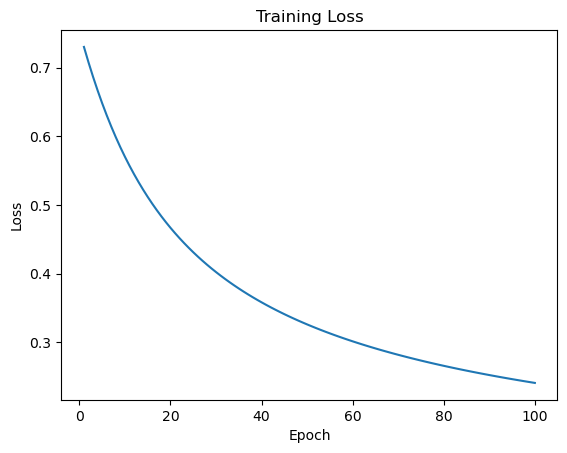

In [9]:
##### Display the training loss values
plt.plot(range(1, n_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

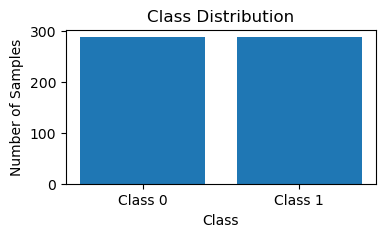

In [10]:
# Count the number of samples in each class in the training data
counts = y_train.sum(dim=0)

# Create a bar plot of the class distribution
plt.figure(figsize=(4, 2))
plt.bar(range(2), counts)
plt.xticks(range(2), ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

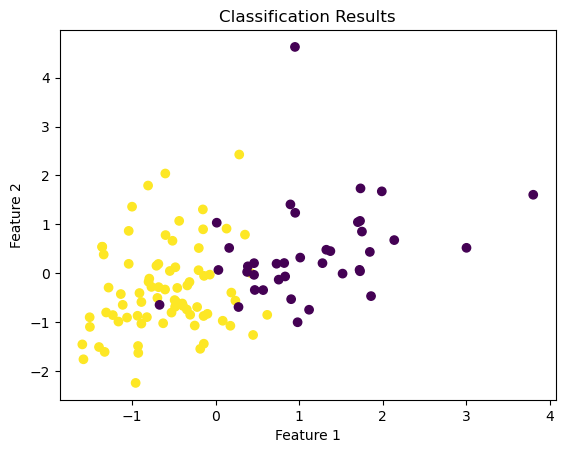

In [11]:
""" Create a scatter plot of the test data points, showing the classification results of the trained logistic regression model.
N.B.
The reshape(-1) method is used to convert the predicted class labels tensor to a one-dimensional array 
that can be used as the c argument in the scatter() function. 
The -1 argument is a placeholder that tells numpy to figure out the size of the new dimension 
based on the size of the original array. 
Here, considering that 'y_predicted_cls' has a shape of (n_samples, 1), the new shape will be (n_samples,), which is a one-dimensional array of length n_samples. 
"""

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predicted_cls.numpy().reshape(-1))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Results')
plt.show()

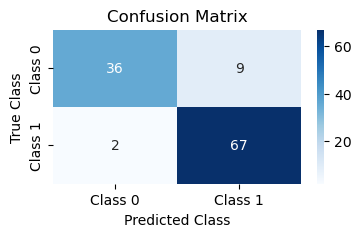

In [12]:
""" Create the confusion matrix of the classification results and plot it as an heatmap. """
cm = confusion_matrix(y_test, y_predicted_cls) 
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

<h3 style="color:#BF66F2 ">  <u> Example #2 </u> </h3>
Wine dataset

In [13]:
class WineDataset(Dataset):
    def __init__(self):
        xy = np.loadtxt('./data/wine_data.csv', delimiter=",", dtype=np.float32, skiprows=1)
        self.x = torch.from_numpy(xy[:, 1:])
        self.y = torch.from_numpy(xy[:, [0]])
        self.num_samples = xy.shape[0]

    def __getitem__(self, index) -> Any:
        #return super().__getitem__(index)
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.num_samples

In [14]:
dataset_wine = WineDataset()
first_data = dataset_wine[0]
features, labels = first_data
print(features, labels)

tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) tensor([1.])


In [15]:
""" Create a DataLoader object.
N.B.1
The batch size of 4 means that each batch of data returned by the DataLoader object will contain 4 samples. 
    - shuffle=True to shuffle the order of the samples in each epoch and improve training performance
    - num_workers=2 to use two worker processes for loading the data in parallel.
N.B.2
The iterator object use the iter() function and passing in the my_dataLoader object, 
    to iterate over the batches of data returned by the DataLoader.
N.B.3
The __next__() method is needed ti get the next batch of data. 
It returns the next batch of data in the form of a tuple containing two tensors: the input features and the target labels.
"""
my_dataLoader = DataLoader(dataset=dataset_wine, batch_size=4, shuffle=True, num_workers=2)
my_dataiter = iter(my_dataLoader)
#data = next(my_dataiter)
data = my_dataiter.__next__()
data


[tensor([[1.2860e+01, 1.3500e+00, 2.3200e+00, 1.8000e+01, 1.2200e+02, 1.5100e+00,
          1.2500e+00, 2.1000e-01, 9.4000e-01, 4.1000e+00, 7.6000e-01, 1.2900e+00,
          6.3000e+02],
         [1.4390e+01, 1.8700e+00, 2.4500e+00, 1.4600e+01, 9.6000e+01, 2.5000e+00,
          2.5200e+00, 3.0000e-01, 1.9800e+00, 5.2500e+00, 1.0200e+00, 3.5800e+00,
          1.2900e+03],
         [1.2330e+01, 9.9000e-01, 1.9500e+00, 1.4800e+01, 1.3600e+02, 1.9000e+00,
          1.8500e+00, 3.5000e-01, 2.7600e+00, 3.4000e+00, 1.0600e+00, 2.3100e+00,
          7.5000e+02],
         [1.2530e+01, 5.5100e+00, 2.6400e+00, 2.5000e+01, 9.6000e+01, 1.7900e+00,
          6.0000e-01, 6.3000e-01, 1.1000e+00, 5.0000e+00, 8.2000e-01, 1.6900e+00,
          5.1500e+02]]),
 tensor([[3.],
         [1.],
         [2.],
         [3.]])]

In [16]:
""" Training loop DUMMY example.
13 different features for each batch => epoch 1/2, step 5/45, inputs torch.Size([4, 13]).
""" 
num_epochs = 2 
total_samples = len(dataset_wine)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(my_dataLoader): #already unpacked
        if (i+1) % 5 == 0: # print infor every 5 steps
            print(f'epoch {epoch + 1 }/{num_epochs}, step {i + 1}/{n_iterations}, inputs {inputs.shape}')

178 45
epoch 1/2, step 5/45, inputs torch.Size([4, 13])
epoch 1/2, step 10/45, inputs torch.Size([4, 13])
epoch 1/2, step 15/45, inputs torch.Size([4, 13])
epoch 1/2, step 20/45, inputs torch.Size([4, 13])
epoch 1/2, step 25/45, inputs torch.Size([4, 13])
epoch 1/2, step 30/45, inputs torch.Size([4, 13])
epoch 1/2, step 35/45, inputs torch.Size([4, 13])
epoch 1/2, step 40/45, inputs torch.Size([4, 13])
epoch 1/2, step 45/45, inputs torch.Size([2, 13])
epoch 2/2, step 5/45, inputs torch.Size([4, 13])
epoch 2/2, step 10/45, inputs torch.Size([4, 13])
epoch 2/2, step 15/45, inputs torch.Size([4, 13])
epoch 2/2, step 20/45, inputs torch.Size([4, 13])
epoch 2/2, step 25/45, inputs torch.Size([4, 13])
epoch 2/2, step 30/45, inputs torch.Size([4, 13])
epoch 2/2, step 35/45, inputs torch.Size([4, 13])
epoch 2/2, step 40/45, inputs torch.Size([4, 13])
epoch 2/2, step 45/45, inputs torch.Size([2, 13])


<h3 style="color:#BF66F2 ">  <u> Example #3 </u> </h3>
MNIST dataset

In [17]:
# Create a PyTorch dataset with the MNIST test data
dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

<div style="line-height:0.5">
<h3 style="color:#BF66F2"> Recap: </h3>
PyTorch provides a 'transforms' module that contains a set of predefined transforms that can be applied to data. <br> 
</div>
<br>
Here are some examples of commonly used <span style="color: #BF66F2;">"transforms"</span>. <br> 
<div style="margin-top: +3px;">

- ToTensor(): 
Converts a PIL Image or numpy.ndarray to a PyTorch tensor. <br> 
It also scales the pixel values to the range [0, 1]. <br> 
- Normalize(mean, std): Normalizes a tensor image with mean and standard deviation. <br> 
It also subtracts the mean from each pixel value and divides by the standard deviation, <br> so that the pixel values have a mean of 0 and a standard deviation of 1.
- RandomCrop(size): Randomly crops a tensor image to the specified size. <br> 
It is often used for data augmentation to introduce randomness into the training data.<br> 
- RandomHorizontalFlip(): Randomly flips a tensor image horizontally with a probability of 0.5.  
It is also used for data augmentation.
- RandomRotation(degrees): Randomly rotates a tensor image by a specified number of degrees.
</div>

<h3 style="color:#BF66F2 ">  <u> Example #4 </u> </h3>
Wine dataset 2

In [18]:
""" Create a new dataset similar to the previous one but extended. 
N.B.
Different from before (example #2)! 
Here, x and y tensors are not created now, but later in the 'customToTensor' class
#self.x = torch.from_numpy(xy[:, 1:])
#self.y = torch.from_numpy(xy[:, [0]])
"""

class WineDataset2(Dataset):
    def __init__(self, transform=None):
        xy = np.loadtxt('./data/wine_data.csv', delimiter=",", dtype=np.float32, skiprows=1)
        self.x = xy[:, 1:]
        self.y = xy[:, [0]]
        self.num_samples = xy.shape[0]
        self.transform = transform


    def __getitem__(self, index) -> Any:
        sample = self.x[index], self.y[index]
        if self.transform: 
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return self.num_samples

In [19]:
class customToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        return torch.from_numpy(inputs), torch.from_numpy(labels)

class customMulTransform:
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, sample):
        inputs, labels = sample
        inputs += self.factor
        return inputs, labels

In [20]:
dataset_wine2 = WineDataset2(transform=customToTensor())
print("dataset_wine2[0]")
print(dataset_wine2[0])

first_data = dataset_wine2[0]
features2, labels2 = first_data
print(f'\nfeatures {features2} \n labels2 {labels2}')
print()
composed = torchvision.transforms.Compose([customToTensor(), customMulTransform(2)])
dataset_wine3 = WineDataset2(transform=composed)
print("Composed:\n  {}".format(composed))
print("Dataset_wine3[0]:\n {}".format(dataset_wine3[0]))

dataset_wine2[0]
(tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]), tensor([1.]))

features tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) 
 labels2 tensor([1.])

Composed:
  Compose(
)
Dataset_wine3[0]:
 (tensor([  16.2300,    3.7100,    4.4300,   17.6000,  129.0000,    4.8000,
           5.0600,    2.2800,    4.2900,    7.6400,    3.0400,    5.9200,
        1067.0000]), tensor([1.]))
